In [1]:

import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split
import GPUtil
import itertools
import pickle
from datetime import datetime
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
from sklearn.preprocessing import Normalizer
import joblib
import ili  # Import ili for the SBI functionality
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

from sbi.utils.user_input_checks import process_prior

sys.path.append("/disk/xray15/aem2/camels/proj2")
from setup_params_1P import plot_uvlf, plot_colour
from setup_params_SB import *
from priors_SB import initialise_priors_SB28
from variables_config_28 import uvlf_limits, n_bins_lf, colour_limits, n_bins_colour
# parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
model = "IllustrisTNG"
spec_type = "attenuated"
sps = "BC03"
snap = ["044"]
bands = "all" # or just GALEX?

colours = False  
luminosity_functions = True
name = f"{model}_{bands}_{sps}_{spec_type}_{n_bins_lf}_{n_bins_colour}"

cam = camels(model=model, sim_set='SB28')

if colours and not luminosity_functions:
    model_out_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/colours_only/"
    plots_out_dir = "/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/colours_only/"
    
elif luminosity_functions and not colours:
    model_out_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/lf_only/"
    plots_out_dir = "/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/lfs_only/"

elif colours and luminosity_functions:
    model_out_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/colours_lfs/"
    plots_out_dir = "/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/colours_lfs/"

else:
    raise ValueError("At least one of colours or luminosity_functions must be True")

print("Saving model in ", model_out_dir)
print("Saving plots in ", plots_out_dir)



/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Saving model in  /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/lf_only/
Saving plots in  /disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/lfs_only/


In [2]:
print(uvlf_limits)

(-25, -14)


In [3]:
# Quick check of available data
with h5py.File("/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/photometry/alice_galex.h5", "r") as hf:
    print("Available simulations:", list(hf.keys()))
    sim_key = list(hf.keys())[0]  # First simulation
    print("\nStructure for first simulation:")
    print(list(hf[f"{sim_key}/snap_044/BC03/photometry/luminosity/attenuated"].keys()))

Available simulations: ['SB28_0', 'SB28_1', 'SB28_10', 'SB28_100', 'SB28_1000', 'SB28_1001', 'SB28_1002', 'SB28_1003', 'SB28_1004', 'SB28_1005', 'SB28_1006', 'SB28_1007', 'SB28_1008', 'SB28_1009', 'SB28_101', 'SB28_1010', 'SB28_1011', 'SB28_1012', 'SB28_1013', 'SB28_1014', 'SB28_1015', 'SB28_1016', 'SB28_1017', 'SB28_1018', 'SB28_1019', 'SB28_102', 'SB28_1020', 'SB28_1021', 'SB28_1022', 'SB28_1023', 'SB28_1024', 'SB28_1025', 'SB28_1026', 'SB28_1027', 'SB28_1028', 'SB28_1029', 'SB28_103', 'SB28_1030', 'SB28_1031', 'SB28_1032', 'SB28_1033', 'SB28_1034', 'SB28_1035', 'SB28_1036', 'SB28_1037', 'SB28_1038', 'SB28_1039', 'SB28_104', 'SB28_1040', 'SB28_1041', 'SB28_1042', 'SB28_1043', 'SB28_1044', 'SB28_1045', 'SB28_1046', 'SB28_1047', 'SB28_1048', 'SB28_1049', 'SB28_105', 'SB28_1050', 'SB28_1051', 'SB28_1052', 'SB28_1053', 'SB28_1054', 'SB28_1055', 'SB28_1056', 'SB28_1057', 'SB28_1058', 'SB28_1059', 'SB28_106', 'SB28_1060', 'SB28_1061', 'SB28_1062', 'SB28_1063', 'SB28_1064', 'SB28_1065', 'SB

          #Name    Omega0    sigma8  WindEnergyIn1e51erg  RadioFeedbackFactor  \
0        SB28_0  0.352541  0.694742              3.85743             1.519210   
1        SB28_1  0.172430  0.830154              1.03554             0.797734   
2        SB28_2  0.234683  0.705844              9.61416             3.380650   
3        SB28_3  0.440288  0.969259              2.14363             0.488165   
4        SB28_4  0.457152  0.786733              1.38466             0.325727   
...         ...       ...       ...                  ...                  ...   
2043  SB28_2043  0.457334  0.970226              8.89733             0.607197   
2044  SB28_2044  0.440496  0.786137              5.34131             0.880840   
2045  SB28_2045  0.234475  0.938760              1.49723             1.873430   
2046  SB28_2046  0.172613  0.612888             13.31250             0.363806   
2047  SB28_2047  0.352358  0.862216              3.09935             3.331570   

      VariableWindVelFactor

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

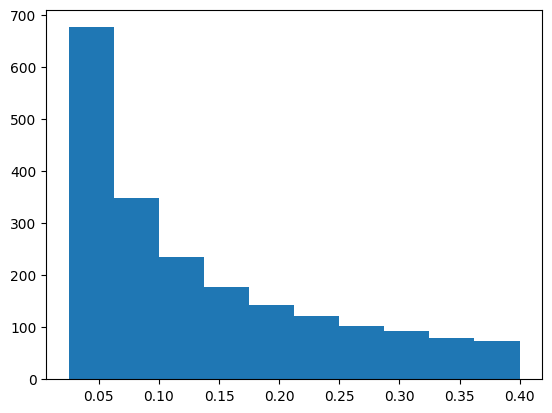

In [4]:
# parameter info file (df_info) is used for defining priors
# the actual parameter values come from the camels class which reads CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt

#  parameters defined here: /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt which is used for theta
df_pars = pd.read_csv('/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt', delim_whitespace=True)
print(df_pars)


# prior values come from this:
df_info = pd.read_csv("/disk/xray15/aem2/data/28pams/Info_IllustrisTNG_L25n256_28params.txt")
print(df_info)

theta = df_pars.iloc[:, 1:29].to_numpy()  # excluding 'name' column and 'seed' column

print(theta)
print(theta.shape)
print("Column names:")
print(df_pars.columns.tolist())
# plot the first one (omega0) to see shape of prior:
plt.hist(theta[:, 24])

if __name__ == "__main__":
    theta, x = get_theta_x_SB(
        luminosity_functions=luminosity_functions,
        colours=colours,
        uvlf_limits=uvlf_limits,
        colour_limits=colour_limits,
        n_bins_lf=n_bins_lf,
        n_bins_colour=n_bins_colour
    )
    print(theta.shape, x.shape)
    
# if __name__ == "__main__":
#     theta, x = get_theta_x_SB(
#         luminosity_functions=luminosity_functions,
#         colours=colours  # This will now override the default
#     )
#     print(theta.shape, x.shape)
    
if colours:
    fig = plot_colour(x)
    #plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/colours_test/colour_check.png')
    plt.show()

if luminosity_functions:
    fig = plot_uvlf(x)
    #plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/LFs_test/uvlf_check.png')
    plt.show()


# get the priors and data
prior = initialise_priors_SB28(
    df=df_info, 
    device=device,
    astro=True,
    dust=False  # no dust for testing. set to False to only get the 28 model parameters.
    # with dust = True, prior has 32 dimensions (28 parameters + 4 dust parameters) 
)

# process the data
x_all = np.array([np.hstack(_x) for _x in x])
x_all = torch.tensor(x_all, dtype=torch.float32, device=device)

print("Theta shape:", theta.shape)
print("X shape:", x_all.shape)


# Move data to GPU as early as possible
x_all = x_all.to(device)
print('x_all:', x_all)

theta = torch.tensor(theta, dtype=torch.float32, device=device)
print('theta:', theta)

# Handle NaN values and normalize while on GPU
x_all_cpu = x_all.cpu().numpy()  # Only move to CPU when necessary for sklearn
print('x_all_cpu:', x_all_cpu)

print("Data shape before processing:", x_all_cpu.shape)
print("Number of values:",(x_all_cpu).sum())
print("Number of NaN values:", np.isnan(x_all_cpu).sum())
print("Number of infinite values:", np.isinf(x_all_cpu).sum())


# get rid of NaN/inf values, replace with small random noise
nan_mask = np.isnan(x_all_cpu) | np.isinf(x_all_cpu)
print('nan_mask:', nan_mask)


if nan_mask.any():
    x_all_cpu[nan_mask] = np.random.rand(np.sum(nan_mask)) * 1e-10

print("Data shape before processing:", x_all_cpu.shape)
print("Number of NaN values:", np.isnan(x_all_cpu).sum())
print("Number of infinite values:", np.isinf(x_all_cpu).sum())

print('x_all_cpu:', x_all_cpu)


# Normalize
norm = Normalizer()

# Option: Add small constant before normalizing
epsilon = 1e-10  # Small constant
x_all_shifted = x_all_cpu + epsilon
x_all_normalized = norm.fit_transform(x_all_shifted)
x_all = torch.tensor(x_all_normalized, dtype=torch.float32, device=device)

print('x_all:', x_all)

# Save normalizer
joblib.dump(norm, f'/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/{name}_scaler.save')

# Print final check
print("Any NaN in normalized data:", torch.isnan(x_all).any().item())
print("Any inf in normalized data:", torch.isinf(x_all).any().item())


# make test mask
test_mask = create_test_mask() # 10% testing
train_mask = ~test_mask # 90% for training


# Training arguments
train_args = {
    "training_batch_size": 64, # changed from 4 to 10 as dealing with more sims, want it to be faster for initial testing.
    "learning_rate": 1e-4,
    "stop_after_epochs": 600, # loss function. waits to see if things improve.
    "validation_fraction": 0.15,  # creates another split within the training data for validation
    "max_num_epochs": 2000  # Add maximum epochs
}

# Configure network
hidden_features = 256 #neurons
num_transforms = 8 #layers
num_nets = 6


In [ ]:
# most recent best: uvlfs only
# hf20_nt2_bs16_lr1e-05_nets3
# renamed for quick screen test:
train_args = {
    "training_batch_size": 64,  # Increase batch size
    "learning_rate": 1e-3,      # Slightly lower learning rate
    "stop_after_epochs": 200,   # Stop earlier
    "validation_fraction": 0.1,  # More validation data
    "max_num_epochs": 1000,
    "clip_max_norm": 5.0        # More aggressive gradient clipping
}


# Reduce model capacity
hidden_features = 5  # Back to original
num_transforms = 1    # Back to original
num_nets = 1       # But keep more ensemble members

# Simple base configuration
nets = [ili.utils.load_nde_sbi(
    engine="NPE",
    model="nsf",
    hidden_features=hidden_features,
    num_transforms=num_transforms,
) for _ in range(num_nets)]

# Runner setup
runner = InferenceRunner.load(
    backend="sbi",
    engine="NPE",
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=model_out_dir,
    name=name
)

# Data loader
loader = NumpyLoader(

    x=x_all[train_mask].clone().detach(),
    theta=theta[train_mask].clone().detach()
)

posterior_ensemble, summaries = runner(loader=loader)



# below is the hyper parameter search

use vis.py to see which one is the best model and use the cell above to re run it to plot results (can also pull results from the grid search)

In [ ]:

# # Define parameter grid
# param_grid = {
#     "hidden_features": [20, 40, 80],
#     "num_transforms": [1, 2, 4, 8],
#     "training_batch_size": [16, 32, 64],
#     "learning_rate": [1e-4, 5e-5, 1e-5],
#     "num_nets": [1, 2, 3]
# }

# # Create output directory with timestamp
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# results_dir = Path(f"grid_search_results_{timestamp}")
# results_dir.mkdir(exist_ok=True)

# # Store all results
# all_results = []

# # Generate all combinations of parameters
# param_combinations = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# def create_run_name(params):
#     """Create a descriptive run name from parameters"""
#     return f"hf{params['hidden_features']}_nt{params['num_transforms']}_bs{params['training_batch_size']}_lr{params['learning_rate']:.0e}_nets{params['num_nets']}"

# for i, params in enumerate(param_combinations):

#     run_name = create_run_name(params)

#     # Update training arguments
#     train_args = {
#         "training_batch_size": params["training_batch_size"],
#         "learning_rate": params["learning_rate"],
#         "stop_after_epochs": 100,
#         "validation_fraction": 0.2,
#         "max_num_epochs": 1000,
#         "clip_max_norm": 5.0
#     }
    
#     # Update model parameters
#     hidden_features = params["hidden_features"]
#     num_transforms = params["num_transforms"]
#     num_nets = params["num_nets"]
    
#     # Create networks
#     nets = [ili.utils.load_nde_sbi(
#         engine="NPE",
#         model="nsf",
#         hidden_features=hidden_features,
#         num_transforms=num_transforms,
#     ) for _ in range(num_nets)]
    
#     # Setup runner
#     run_dir = results_dir / run_name
#     run_dir.mkdir(exist_ok=True)
    
#     runner = InferenceRunner.load(
#         backend="sbi",
#         engine="NPE",
#         prior=prior,
#         nets=nets,
#         device=device,
#         train_args=train_args,
#         proposal=None,
#         out_dir=run_dir,
#         name=run_name
#     )
    
#     # Data loader
#     loader = NumpyLoader(
#         x=x_all[train_mask].clone().detach(),
#         theta=theta[train_mask].clone().detach()
#     )
    
#     # Train model
#     posterior_ensemble, summaries = runner(loader=loader)
    
#     # Store results
#     result = {
#         "parameters": params,
#         "summaries": summaries,
#         "posterior_ensemble": posterior_ensemble,
#         "train_args": train_args
#     }
    
#     all_results.append(result)
    
#     # Save individual run results
#     with open(run_dir / "results.pkl", "wb") as f:
#         pickle.dump(result, f)
    
#     # Print progress
#     print(f"Completed run {i+1}/{len(param_combinations)}")
#     # print(f"Parameters: {params}")
#     # print(f"Validation loss: {summaries.get('validation_loss', 'N/A')}")
#     print("-" * 50)

# # Save all results to a single file
# with open(results_dir / "all_results.pkl", "wb") as f:
#     pickle.dump(all_results, f)

# # Create a summary file
# # with open(results_dir / "summary.txt", "w") as f:
# #     f.write("Grid Search Results Summary\n")
#     # f.write(f"Timestamp: {timestamp}\n\n")
    
#     # for i, result in enumerate(all_results):
#         # f.write(f"Run {i+1}:\n")
#         # f.write(f"Parameters: {result['parameters']}\n")
#         # f.write(f"Validation loss: {result['summaries'].get('validation_loss', 'N/A')}\n")
#         # f.write("-" * 50 + "\n")

In [ ]:
#hf20_nt2_bs16_lr1e-04_nets1.png


In [ ]:
x_train=x_all[train_mask].clone().detach(),
theta_train=theta[train_mask].clone().detach()


In [ ]:
posterior_ensemble

In [ ]:
summaries

In [ ]:
print("training_batch_size", train_args[ "training_batch_size"])
print("learning_rate", train_args[ "learning_rate"])
print("stop_after_epochs", train_args[ "stop_after_epochs"])
print("validation_fraction", train_args[ "validation_fraction"])
print("hidden_features", hidden_features)
print("num_transforms", num_transforms)
print("num_nets", num_nets)



In [ ]:
def plot_training_diagnostics(summaries):
    """Plot training diagnostics without empty subplots"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Changed to 1 row, 2 columns
    
    # Loss curves
    train_losses = summaries[0]['training_log_probs']
    val_losses = summaries[0]['validation_log_probs']
    epochs = range(len(train_losses))
    
    ax1.plot(epochs, train_losses, '-', label='Training', color='blue')
    ax1.plot(epochs, val_losses, '--', label='Validation', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Log probability')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Overfitting gap
    gap = np.array(train_losses) - np.array(val_losses)
    ax2.plot(epochs, gap, '-', color='purple')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss difference')
    ax2.set_title('Overfitting Gap')
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# refer back to training args in file name
model_params = f"batch{train_args['training_batch_size']}_" \
               f"lr{train_args['learning_rate']:.0e}_" \
               f"epochs{train_args['stop_after_epochs']}_" \
               f"val{train_args['validation_fraction']}_" \
               f"hidden{hidden_features}_" \
               f"transforms{num_transforms}"

# Use the function
fig = plot_training_diagnostics(summaries)
plt.savefig(os.path.join(plots_out_dir, f'loss_overfitting_{model_params}.png'))
plt.show()
plt.close()

In [ ]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [14]:
# will this work or do we have to use it explicitly?
x_train=x_all[train_mask].clone().detach(),
theta_train=theta[train_mask].clone().detach()


### Drawing samples from the entire test set to look at overall performance of the model

In [ ]:
# Get test data
x_test = x_all[test_mask]
theta_test = theta[test_mask]

# Number of samples to draw from posterior
n_samples = 1000

# Storage for predictions
all_samples = []
all_means = []
all_stds = []

# Generate posterior samples for each test point
for i in range(len(x_test)):
    # Get samples from the posterior
    samples = posterior_ensemble.sample(
        (n_samples,), 
        x=x_test[i].reshape(1, -1)
    ).cpu().numpy()
    
    # Calculate mean and std of samples
    mean = samples.mean(axis=0)
    std = samples.std(axis=0)
    
    all_samples.append(samples)
    all_means.append(mean)
    all_stds.append(std)

all_samples = np.array(all_samples)
all_means = np.array(all_means)
all_stds = np.array(all_stds)

In [ ]:
param_names = df_pars.columns[1:29].tolist()  # excluding 'name' column

fig, axes = plt.subplots(7, 4, figsize=(16, 28)) 
axes = axes.flatten()

fontsize = 10  

plt.rcParams['figure.constrained_layout.use'] = True  

# plot each parameter
for i in range(28):
    ax = axes[i]
    
    # true vs predicted with error bars
    ax.errorbar(
        theta_test[:, i].cpu().numpy(),
        all_means[:, i],
        yerr=all_stds[:, i],
        fmt='.',
        color='k',
        ecolor='blue',
        capsize=0,
        elinewidth=0.8,  
        alpha=0.3,       
        markersize=5    
    )
    
    # add true line
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])
    ]
    ax.plot(lims, lims, '--', color='black', alpha=0.5, linewidth=1)
    
    # get metrics
    rmse = np.sqrt(np.mean((theta_test[:, i].cpu().numpy() - all_means[:, i])**2))
    r2 = np.corrcoef(theta_test[:, i].cpu().numpy(), all_means[:, i])[0, 1]**2
    chi2 = np.mean(((theta_test[:, i].cpu().numpy() - all_means[:, i])**2) / (all_stds[:, i]**2))
    
    # add metrics box in top left corner
    stats_text = f'RMSE = {rmse:.2f}\n' + \
                 f'R² = {r2:.2f}\n' + \
                 f'χ² = {chi2:.2f}'
    ax.text(0.05, 0.95, stats_text,
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8),
            verticalalignment='top',
            fontsize=fontsize-1)  # Slightly smaller font for stats
    
    # title: parameter name
    ax.set_title(param_names[i], fontsize=fontsize, pad=5)  # Reduced padding
    
    # axis labels
    ax.set_xlabel('True', fontsize=fontsize-1)
    ax.set_ylabel('Inferred', fontsize=fontsize-1)
    
    # tick labels
    ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
    
    # internal padding
    ax.margins(x=0.05, y=0.05)

# subplot spacing
plt.subplots_adjust(
    left=0.01,    # Less space on left
    right=0.7,   # Less space on right
    bottom=0.05,  # Less space at bottom
    top=0.7,     # Less space at top
    wspace=0.2,   # Less space between plots horizontally
    hspace=0.2    # Less space between plots vertically
)


# save 
save_path = f'{plots_out_dir}/posterior_predictions_{model_params}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
print(save_path)
plt.show()

In [ ]:
config_str = (f"batch{train_args['training_batch_size']}_"
             f"lr{train_args['learning_rate']}_"
             f"epochs{train_args['stop_after_epochs']}_"
             f"h{hidden_features}_t{num_transforms}")

# coverage plots
metric = PosteriorCoverage(
    num_samples=int(4e3),
    sample_method='direct',
    labels=cam.labels,
    plot_list=["tarp"], # "coverage", "histogram", "predictions", 
    out_dir=plots_out_dir,
)

# make plots
figs = metric(
    posterior=posterior_ensemble,
    x=x_all[test_mask].cpu(),
    theta=theta[test_mask, :].cpu(),
    signature=f"coverage_{name}_{config_str}_"  # Add config to filename
)

config_text = (
    f"Training Config:\n"
    f"Batch Size: {train_args['training_batch_size']}\n"
    f"Learning Rate: {train_args['learning_rate']}\n"
    f"Epochs: {train_args['stop_after_epochs']}\n"
    f"Hidden Features: {hidden_features}\n"
    f"Num Transforms: {num_transforms}"
)

# make each figure
for i, fig in enumerate(figs):
    plt.figure(fig.number)  # activate the figure
    plt.figtext(0.02, 0.98, config_text,
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
                verticalalignment='top')
    
    # save each figure with type indicator
    plot_types = ["tarp"] #"coverage", "histogram", "predictions",
    plt.savefig(os.path.join(plots_out_dir, 
                f'metric_{plot_types[i]}_{name}_{config_str}.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

### Looking at a specific case (one observation randomly set with seed)

In [ ]:
# Now, SBIRunner returns a custom class instance to be able to pass signature strings
# 1. prints our info on model configuration and architecture
print(posterior_ensemble.signatures)


# 2. choose a random input for training
seed_in = 49
np.random.seed(seed_in) # set seed for reproducability
ind = np.random.randint(len(x_train[0])) # choose observation (random index from training data)

# 3. generate posterior samples
seed_samp = 32
torch.manual_seed(seed_samp)# set seed for reproducability
# then, for the chosen training sample (as chosen above in 2.)
# generate 1000 samples from the posterior distribution using accept/reject sampling
samples = posterior_ensemble.sample(
    (1000,), 
    torch.Tensor(x_train[0][ind]).to(device))

# 4. calculate the probability densities for each sample
# i.e for each generated sample, calculate how likely it is using learned posterior distribution
log_prob = posterior_ensemble.log_prob(
    samples, # the generated samples from 3.
    torch.Tensor(x_train[0][ind]).to(device) # the chosen observation from 2.
    )

# convert to numpy so can read easier.
samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

from matplotlib.gridspec import GridSpec
def plot_posterior_samples_grid(samples, log_prob, param_names, df_info, model_name, train_args):
   n_params = len(param_names)
   n_cols = 4
   n_rows = (n_params + n_cols - 1) // n_cols
   
   fig = plt.figure(figsize=(20, 5*n_rows))
   
   # Add main title
   fig.suptitle('Posterior Probability Distributions', fontsize=16, y=0.98)
   
   gs = GridSpec(n_rows, n_cols, figure=fig)
   
   # Model info text
   model_info = (
       f"Model Config:\n"
       f"Name: {model_name}\n"
       f"Hidden Features: {hidden_features}\n"
       f"Num Transforms: {num_transforms}\n"
       f"\nTraining Args:\n"
       f"Batch Size: {train_args['training_batch_size']}\n"
       f"Learning Rate: {train_args['learning_rate']}\n"
       f"Stop After Epochs: {train_args['stop_after_epochs']}"
   )
   
   fig.text(0.02, 0.96, model_info, 
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
            verticalalignment='top')
   
   for i, name in enumerate(param_names):
       row = i // n_cols
       col = i % n_cols
       
       ax = fig.add_subplot(gs[row, col])
       data = samples[:, i]
       param_info = df_info[df_info['ParamName'] == name].iloc[0]
       is_log = param_info['LogFlag'] == 1
       
       if is_log:
           ax.hist(data, bins=50, density=True, alpha=0.6)
           ax.set_xscale('log')
           log_data = np.log10(data)
           mean = np.mean(log_data)
           std = np.std(log_data)
           stats_text = f'Log10 Mean: {mean:.3f}\nLog10 Std: {std:.3f}'
           ax.set_xlabel('Parameter Value (log scale)', fontsize=8)
       else:
           ax.hist(data, bins=50, density=True, alpha=0.6)
           mean = np.mean(data)
           std = np.std(data)
           stats_text = f'Mean: {mean:.3f}\nStd: {std:.3f}'
           ax.set_xlabel('Parameter Value', fontsize=8)
       
       ax.set_ylabel('Density', fontsize=8)
       
       ax.axvline(param_info['MinVal'], color='g', linestyle=':', alpha=0.5, label='Min')
       ax.axvline(param_info['MaxVal'], color='g', linestyle=':', alpha=0.5, label='Max')
       ax.axvline(param_info['FiducialVal'], color='r', linestyle='--', alpha=0.5, label='Fiducial')
       
       ax.text(0.02, 0.95, stats_text, transform=ax.transAxes, 
               verticalalignment='top', fontsize=8, 
               bbox=dict(facecolor='white', alpha=0.8))
       
       ax.set_title(f"{name}\n{param_info['Description']}", fontsize=8, pad=5)
       ax.tick_params(labelsize=8)
       
       if i == 0:
           ax.legend(loc='upper right', fontsize=8)
   
   plt.tight_layout()
   plt.subplots_adjust(top=0.93)  # Adjusted to make room for main title
   return fig

# Get all parameter names from df_info
param_names = df_info['ParamName'].tolist()

# Now try plotting again with the correct parameter names
fig = plot_posterior_samples_grid(
    samples, 
    log_prob, 
    param_names,  # Now contains all 28 parameter names correctly
    df_info,
    model_name=name,
    train_args=train_args
)

# Save with model config in filename
save_name = (f'parameter_posteriors_grid_{name}_'
            f'h{hidden_features}_t{num_transforms}_'
            f'b{train_args["training_batch_size"]}_'
            f'e{train_args["stop_after_epochs"]}.png')

os.makedirs(plots_out_dir, exist_ok=True)
plt.savefig(os.path.join(plots_out_dir, save_name), 
            dpi=300, 
            bbox_inches='tight')